# Audio Transcription and Analysis

This notebook provides functionality for:
1. Audio file preprocessing using FFmpeg
2. Transcription using Whisper
3. Audio analysis including language detection and log-mel spectrogram visualization

In [1]:
# Required imports
import whisper
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

## Audio Preprocessing
Extract a portion of the audio file using FFmpeg

In [4]:
def extract_audio_segment(input_file, output_file, start_time, duration):
    """
    Extract a segment of audio using FFmpeg
    start_time: format 'HH:MM:SS'
    duration: format 'HH:MM:SS'
    """
    command = f'ffmpeg -i {input_file} -ss {start_time} -t {duration} -c copy {output_file}'
    !{command}

# Example usage:
# extract_audio_segment('input.wav', 'output.wav', '02:00', '03:00')

## Model Setup
Initialize the Whisper model and check available models

In [3]:
# Display available models
print("Available Whisper models:")
print(whisper.available_models())

# Release dates form model card dd 09-2024:
# September 2022 (original series), December 2022 (large-v2), November 2023 (large-v3), September 2024 (large-v3-turbo)

Available Whisper models:
['tiny.en', 'tiny', 'base.en', 'base', 'small.en', 'small', 'medium.en', 'medium', 'large-v1', 'large-v2', 'large-v3', 'large', 'large-v3-turbo', 'turbo']


In [6]:
# Load the model
MODEL_SIZE = 'large-v3-turbo'  # Can be changed to any available model
print(f"\nLoading {MODEL_SIZE} model...")
model = whisper.load_model(MODEL_SIZE)
print("Model loaded successfully!")


Loading large-v3-turbo model...


c:\Projects\Whisper\.venv\Lib\site-packages\whisper\__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp, map_location=device)


Model loaded successfully!


## Audio Analysis
Analyze audio properties including log-mel spectrogram and language detection

In [7]:
def analyze_audio(audio_path):
    """Perform comprehensive audio analysis"""
    # Load and pad audio
    audio = whisper.load_audio(audio_path)
    audio = whisper.pad_or_trim(audio)

    # Generate log-mel spectrogram
    mel = whisper.log_mel_spectrogram(audio, n_mels=model.dims.n_mels).to(model.device)

    # Detect language
    _, probs = model.detect_language(mel)
    detected_lang = max(probs, key=probs.get)
    print(f"Detected language: {detected_lang}")
    print("\nLanguage probabilities:")
    for lang, prob in sorted(probs.items(), key=lambda x: x[1], reverse=True)[:5]:
        print(f"{lang}: {prob:.3f}")

    # Visualize spectrogram
    plt.figure(figsize=(15, 5))
    plt.imshow(mel.cpu().numpy(), aspect='auto', origin='lower')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Log-mel Spectrogram')
    plt.xlabel('Time')
    plt.ylabel('Mel bins')
    plt.show()

    return mel, detected_lang

# Example usage:
# mel, detected_lang = analyze_audio('your_audio.wav')

## Transcription
Transcribe audio with different approaches

In [9]:
def transcribe_audio(audio_path, method='simple'):
    """Transcribe audio using either simple or detailed method"""
    if method == 'simple':
        # Simple transcription
        result = model.transcribe(audio_path)
        return result['text']
    else:
        # Detailed transcription with custom options
        audio = whisper.load_audio(audio_path)
        audio = whisper.pad_or_trim(audio)
        mel = whisper.log_mel_spectrogram(audio, n_mels=model.dims.n_mels).to(model.device)
        
        options = whisper.DecodingOptions(
            fp16=False,  # Use FP32 on CPU
            language=None,  # Auto-detect language
            task='transcribe'
        )
        result = whisper.decode(model, mel, options)
        return result.text

def save_transcription(text, output_path):
    """Save transcription to a text file"""
    os.makedirs(os.path.dirname(output_path) or '.', exist_ok=True)
    with open(output_path, "w", encoding='utf-8') as f:
        f.write(text)
    print(f"Transcription saved to: {output_path}")

## Complete Pipeline
Run the complete analysis and transcription pipeline

In [12]:
def process_audio(input_file, output_dir='Transcription', segment=None):
    """Complete audio processing pipeline"""
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Extract segment if specified
    if segment:
        start_time, duration = segment
        segment_file = os.path.join(output_dir, 'segment.wav')
        extract_audio_segment(input_file, segment_file, start_time, duration)
        audio_file = segment_file
    else:
        audio_file = input_file

    # Analyze audio
    print("\nAnalyzing audio...")
    mel, detected_lang = analyze_audio(audio_file)

    # Perform transcription
    print("\nTranscribing audio...")
    simple_trans = transcribe_audio(audio_file, method='simple')
    detailed_trans = transcribe_audio(audio_file, method='detailed')

    # Save results
    save_transcription(simple_trans, os.path.join(output_dir, 'simple_transcription.txt'))
    save_transcription(detailed_trans, os.path.join(output_dir, 'detailed_transcription.txt'))

    return {
        'language': detected_lang,
        'simple_transcription': simple_trans,
        'detailed_transcription': detailed_trans
    }

# Example usage:
# results = process_audio('input.wav', segment=('02:00', '03:00'))


Analyzing audio...
Detected language: nl

Language probabilities:
nl: 0.999
en: 0.001
de: 0.000
fr: 0.000
es: 0.000


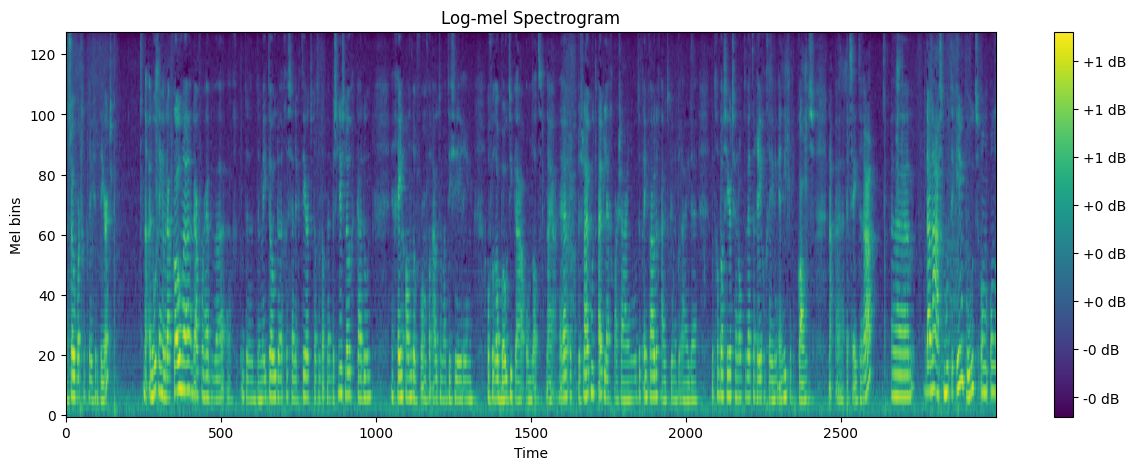


Transcribing audio...


c:\Projects\Whisper\.venv\Lib\site-packages\whisper\transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcription saved to: Transcription\simple_transcription.txt
Transcription saved to: Transcription\detailed_transcription.txt


{'language': 'nl',
 'simple_transcription': " Zo wordt gepresenteerd. En hoe gingen we daar komen? Daarvoor hebben we de methode geselecteerd dat we dat met beslislogica doen. En geen andere vorm van automatisering of robotica. Omdat het besluit moet uitlegbaar zijn. Je moet het eenvoudig uit kunnen breiden. Je moet gebaseerd zijn op de wet en regelgeving en niet op kans. Nou, et cetera. Daarnaast moet de input, om dat automatisch voorvullen te realiseren, moet gestructureerd worden. Want hoe weet de computer nou dat bepaalde zinnen uit een medisch document slaan op oriëntatie in tijd of plaats, bijvoorbeeld. Nou, dat is iets wat we de computer moeten vertellen. Want anders kan hij niet zelfstandig de informatie op de juiste plek zetten. En daar hebben we Natural Language Processing voor. Nou ja, eigenlijk daarmee geëxperimenteerd. En dat blijkt een heel goede methode om eigenlijk uit documenten die binnenkomen de informatie te filteren. Van wat is relevant en wat is irrelevant. En voo

In [13]:
process_audio('Audio/segment.wav')